## Importing Modules and Liberaries

In [1]:
import pandas as pd
import numpy as np
import random
import string
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import regularizers,optimizers,models,layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
import matplotlib.pyplot as plt

2024-07-26 18:29:21.025030: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-26 18:29:21.088168: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 18:29:21.088214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 18:29:21.089819: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-26 18:29:21.098957: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-26 18:29:21.099482: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Loading Data

In [2]:
base_dir = "news_articles.csv"
data = pd.read_csv(base_dir)
shuffle = data.values.tolist()
random.shuffle(shuffle)
data = pd.DataFrame(shuffle,columns=data.columns)

## Preprocessing Data

In [3]:
print(data.head())

          author                      published  \
0      Anonymous  2016-10-29T22:36:00.000+03:00   
1  Mikael Thalen  2016-10-29T13:10:13.738+03:00   
2      No Author  2016-10-27T01:27:23.314+03:00   
3      No Author  2016-11-14T01:54:13.190+02:00   
4      No Author  2016-10-27T05:55:35.956+03:00   

                                               title  \
0                                           no title   
1            world community fears hillary kill list   
2                 are tensions with russia even real   
3  people arrested for food stamp fraud guess how...   
4                iranian products on display in kiev   

                                                text language  \
0  the second video bottom one  proves what trump...  english   
1  votes being switched in multiple states to cli...  english   
2  part  mother  child worship httpswwwyoutubecom...  english   
3  on november    pm  \nit was just a few days ag...  english   
4  iran raps rare eu clauses in

In [4]:
data.isna().sum()

author                      0
published                   0
title                       0
text                       46
language                    1
site_url                    1
main_img_url                1
type                        1
label                       1
title_without_stopwords     2
text_without_stopwords     50
hasImage                    1
dtype: int64

In [5]:
data = data.dropna(subset=['label'])

In [6]:
data.isna().sum()

author                      0
published                   0
title                       0
text                       45
language                    0
site_url                    0
main_img_url                0
type                        0
label                       0
title_without_stopwords     1
text_without_stopwords     49
hasImage                    0
dtype: int64

In [7]:
data = data.fillna("")

In [8]:
data.isna().sum()

author                     0
published                  0
title                      0
text                       0
language                   0
site_url                   0
main_img_url               0
type                       0
label                      0
title_without_stopwords    0
text_without_stopwords     0
hasImage                   0
dtype: int64

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize global stopwords and lemmatizer




def stem_text(text):
    stemmer = PorterStemmer()
    words = text.split(" ")
    refined_text = " ".join(stemmer.stem(word) for word in words)
    return refined_text
    
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    refined_text = " ".join(word for word in words if word.lower() not in stop_words)
    return refined_text
    
def lemmatize_text(corpus):
    lemmatizer = WordNetLemmatizer()
    lemmatized_corpus = []

    for sentence in corpus:
        refined_text = ""
        words = sentence.split(" ")
        for word in words:
            refined_text += lemmatizer.lemmatize(word) + " "
        lemmatized_corpus.append(refined_text.strip())

    return lemmatized_corpus

def preprocess_text(reviews):
    punctuation = string.punctuation
    corpus = []

    for review in reviews:
        review = review.replace('<br />', '')

        refined_text = ''
        
        for char in review:
            if char not in punctuation:
                refined_text += char

        corpus.append(refined_text)

    return corpus


[nltk_data] Downloading package stopwords to /home/hassan-ahmed-
[nltk_data]     khan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hassan-ahmed-
[nltk_data]     khan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
data["title"] = preprocess_text(data["title"].tolist())

data["title"] = data["title"].apply(remove_stopwords)

data["title"] = data["title"].apply(stem_text)

lemmatized_corpus = lemmatize_text(data["title"].tolist())
data["title"] = lemmatized_corpus



data["text"] = preprocess_text(data["text"].tolist())

data["text"] = data["text"].apply(remove_stopwords)

data["text"] = data["text"].apply(stem_text)

lemmatized_corpus = lemmatize_text(data["text"].tolist())
data["text"] = lemmatized_corpus



In [11]:
columns = ['author', 'title', 'text', 'language', 'site_url']
data['combined_text'] = data[columns].apply(lambda row: ' '.join(str(value) for value in row if pd.notna(value)), axis=1)

In [12]:

X = data['combined_text'].tolist()
Y = data['label'].map({"Real":1,"Fake":0}).tolist()

df = pd.DataFrame({'X': X,'Y': Y})

print(df.head())

                                                   X  Y
0  Anonymous titl second video bottom one prove t...  0
1  Mikael Thalen world commun fear hillari kill l...  0
2  No Author tension russia even real part mother...  0
3  No Author peopl arrest food stamp fraud guess ...  1
4  No Author iranian product display kiev iran ra...  1


In [13]:
max_features = 10000 
max_len = 1000  
trunc_type = 'post'  
padding_type = 'post'  
oov_tok = '<OOV>'  

tokenizer = Tokenizer(num_words=max_features, oov_token=oov_tok)

tokenizer.fit_on_texts(df['X'])

sequences = tokenizer.texts_to_sequences(df['X'])

padded_sequences = pad_sequences(sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

df['processed_text'] = list(padded_sequences)

print(df)

                                                      X  Y  \
0     Anonymous titl second video bottom one prove t...  0   
1     Mikael Thalen world commun fear hillari kill l...  0   
2     No Author tension russia even real part mother...  0   
3     No Author peopl arrest food stamp fraud guess ...  1   
4     No Author iranian product display kiev iran ra...  1   
...                                                 ... ..   
2090  No Author obama slam trump rig elect claim dan...  0   
2091  No Author debunk photo obama speech balloo cli...  0   
2092  André du Pôle socal intellectu harm good socie...  1   
2093  No Author babylon mysteri religion book httpww...  0   
2094  No Author pour booster le vent dassault offr u...  0   

                                         processed_text  
0     [1950, 409, 337, 120, 2203, 4, 839, 2, 8707, 4...  
1     [5380, 5381, 44, 184, 475, 5, 185, 459, 28, 74...  
2     [132, 56, 2097, 117, 27, 255, 127, 1050, 143, ...  
3     [132, 56, 7, 483,

In [14]:
print(df['processed_text'])

0       [1950, 409, 337, 120, 2203, 4, 839, 2, 8707, 4...
1       [5380, 5381, 44, 184, 475, 5, 185, 459, 28, 74...
2       [132, 56, 2097, 117, 27, 255, 127, 1050, 143, ...
3       [132, 56, 7, 483, 130, 2975, 692, 1694, 45, 12...
4       [132, 56, 1176, 431, 1589, 5119, 415, 5629, 17...
                              ...                        
2090    [132, 56, 33, 3016, 2, 429, 13, 108, 489, 22, ...
2091    [132, 56, 3668, 458, 33, 368, 1, 5245, 1506, 4...
2092    [5655, 1907, 8753, 1284, 1446, 1051, 102, 406,...
2093    [132, 56, 6737, 2298, 955, 315, 1, 2583, 120, ...
2094    [132, 56, 1984, 1, 173, 6863, 1, 1, 541, 1, 54...
Name: processed_text, Length: 2095, dtype: object


In [15]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
# print(len(sequence[0]))
print(word_index['the'])

Found 34296 unique tokens.
4255


In [16]:
# data = data[:len(data) - len(data) * 0.3]
# x_val = data[:len(data) - len(data) * 0.3]
train_data = df[:int(len(df) * 0.6)]
valid_data = df[int(len(df) * 0.6):int(len(df) * 0.8)]
test_data = df[int(len(df) * 0.8):]
print(len(train_data))
print(len(valid_data))
print(len(data))

1257
419
2095


In [17]:
x_train = np.array(list(train_data['processed_text']))
y_train = np.array(train_data['Y'])
x_valid = np.array(list(valid_data['processed_text']))
y_valid = np.array(valid_data['Y'])
x_test = np.array(list(test_data['processed_text']))
y_test = np.array(test_data['Y'])


In [18]:
print(x_train.shape)
print(y_train.shape) 

(1257, 1000)
(1257,)


## Training Model

In [19]:
model = models.Sequential()
model.add(layers.Embedding(10000,32,input_length=max_len))
model.add(layers.Flatten())
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

In [20]:
history= model.fit(x_train,y_train,epochs=20,batch_size=32,validation_data=(x_valid,y_valid))

Epoch 1/20
40/40 [==============================] - 1s 15ms/step - loss: 0.6616 - acc: 0.6126 - val_loss: 0.6481 - val_acc: 0.6110
Epoch 2/20
40/40 [==============================] - 0s 10ms/step - loss: 0.5873 - acc: 0.6818 - val_loss: 0.6169 - val_acc: 0.6181
Epoch 3/20
40/40 [==============================] - 0s 10ms/step - loss: 0.4910 - acc: 0.7940 - val_loss: 0.5732 - val_acc: 0.6659
Epoch 4/20
40/40 [==============================] - 0s 10ms/step - loss: 0.3759 - acc: 0.9165 - val_loss: 0.5215 - val_acc: 0.7232
Epoch 5/20
40/40 [==============================] - 0s 10ms/step - loss: 0.2687 - acc: 0.9634 - val_loss: 0.4477 - val_acc: 0.8043
Epoch 6/20
40/40 [==============================] - 0s 10ms/step - loss: 0.1835 - acc: 0.9865 - val_loss: 0.4091 - val_acc: 0.8043
Epoch 7/20
40/40 [==============================] - 0s 10ms/step - loss: 0.1222 - acc: 0.9889 - val_loss: 0.3756 - val_acc: 0.8234
Epoch 8/20
40/40 [==============================] - 0s 10ms/step - loss: 0.0822 - a

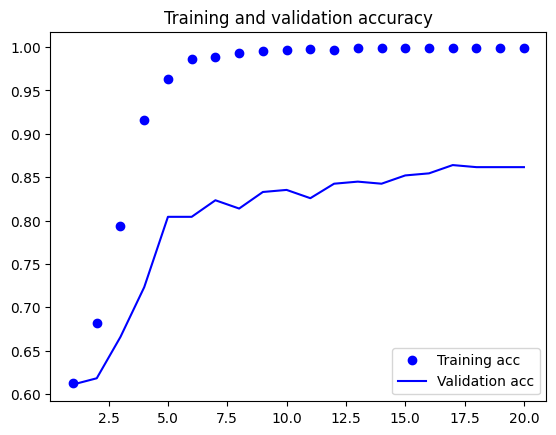

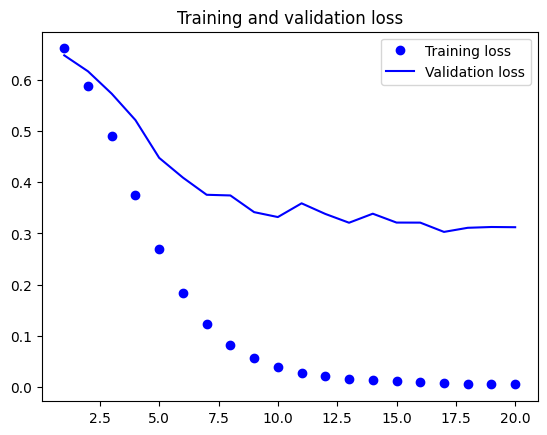

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Testing Model

In [22]:
model.evaluate(x_test,y_test)

14/14 [==============================] - 0s 4ms/step - loss: 0.3491 - acc: 0.8687


[0.3491125702857971, 0.8687350749969482]

### Using Glove.6B for Word Embedding

In [23]:
embedding = {}
num_words = 10000
embedding_dim = 100

glove_dir = r'glove.6b/glove.6B.100d.txt'
with open(glove_dir, 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coef = np.array(values[1:], 'float32')
        embedding[word] = coef

for word, coef in list(embedding.items())[:5]:
    print(f'{word}: {coef}')




the: [-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459
  0.8278    0.27

In [24]:
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embedding.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print(embedding_matrix)


[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.15730999 -0.75502998  0.36844999 ... -0.54136997  0.67817003
  -0.17251   ]
 ...
 [-0.97762001 -0.63091999 -0.35613999 ... -0.81704998  0.041152
  -0.18785   ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [34]:
model = models.Sequential()
model.add(layers.Embedding(num_words, embedding_dim, input_length=max_len))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1000, 100)         1000000   
                                                                 
 flatten_2 (Flatten)         (None, 100000)            0         
                                                                 
 dense_7 (Dense)             (None, 32)                3200032   
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4200065 (16.02 MB)
Trainable params: 4200065 (16.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [36]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

In [37]:
checkpoint_callback = ModelCheckpoint('./Saved_Models/Sentiment Analysis.h5', monitor='val_acc', save_best_only=True, mode='max')

In [38]:
history = model.fit(x_train, y_train,epochs=20,batch_size=32,validation_data=(x_valid, y_valid),callbacks=[checkpoint_callback])

Epoch 1/20
40/40 [==============================] - 3s 55ms/step - loss: 0.7383 - acc: 0.6523 - val_loss: 0.8483 - val_acc: 0.6158
Epoch 2/20
40/40 [==============================] - 2s 44ms/step - loss: 0.3610 - acc: 0.8377 - val_loss: 0.7096 - val_acc: 0.5990
Epoch 3/20
40/40 [==============================] - 2s 49ms/step - loss: 0.1183 - acc: 0.9698 - val_loss: 0.6384 - val_acc: 0.6969
Epoch 4/20
40/40 [==============================] - 2s 45ms/step - loss: 0.0336 - acc: 0.9936 - val_loss: 1.7043 - val_acc: 0.6659
Epoch 5/20
40/40 [==============================] - 2s 44ms/step - loss: 0.0318 - acc: 0.9984 - val_loss: 1.1680 - val_acc: 0.6635
Epoch 6/20
40/40 [==============================] - 2s 44ms/step - loss: 0.0050 - acc: 0.9984 - val_loss: 0.8850 - val_acc: 0.6826
Epoch 7/20
40/40 [==============================] - 2s 44ms/step - loss: 0.0024 - acc: 0.9992 - val_loss: 0.9389 - val_acc: 0.6874
Epoch 8/20
40/40 [==============================] - 2s 44ms/step - loss: 0.0017 - a

In [39]:
num_words = 10000

In [40]:

model = models.Sequential()

model.add(layers.Embedding(10000,100,input_length=max_len))

model.add(layers.SimpleRNN(128, return_sequences=True))
model.add(layers.SimpleRNN(64))

model.add(layers.BatchNormalization())

model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])


model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1000, 100)         1000000   
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 1000, 128)         29312     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 64)                12352     
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                      

In [41]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [42]:
checkpoint_callback = ModelCheckpoint('./Saved_Models/Sentiment Analysis.h5', monitor='val_acc', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_acc', patience=3, restore_best_weights=True)

history = model.fit(x_train, y_train,epochs=30,batch_size=32,validation_data=(x_valid, y_valid),callbacks=[early_stopping,checkpoint_callback])

Epoch 1/30
40/40 [==============================] - 38s 888ms/step - loss: 0.7930 - acc: 0.6213 - val_loss: 0.7832 - val_acc: 0.6229
Epoch 2/30
40/40 [==============================] - 36s 892ms/step - loss: 0.7992 - acc: 0.5998 - val_loss: 0.7824 - val_acc: 0.6014
Epoch 3/30
40/40 [==============================] - 42s 1s/step - loss: 0.7804 - acc: 0.6062 - val_loss: 0.7722 - val_acc: 0.6110
Epoch 4/30
40/40 [==============================] - 47s 1s/step - loss: 0.7737 - acc: 0.6126 - val_loss: 0.7663 - val_acc: 0.6110


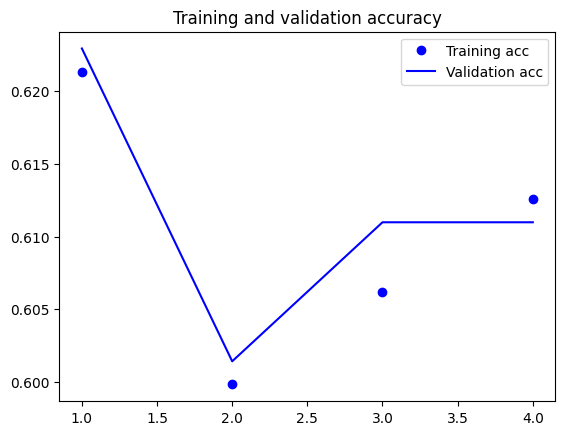

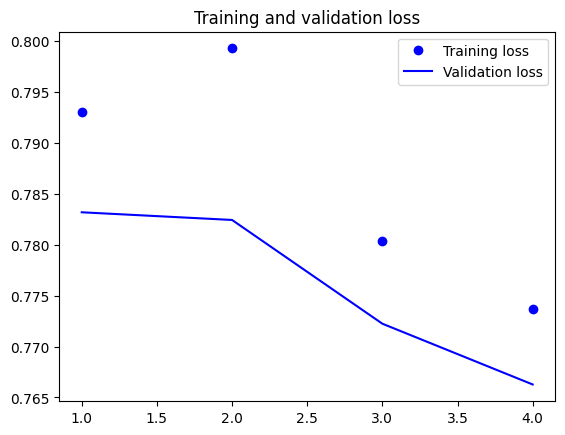

In [43]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [44]:
model = models.Sequential()
model.add(layers.Embedding(10000,100,input_length=max_len))
model.add(layers.LSTM(32))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizer= optimizers.RMSprop(),loss='binary_crossentropy',metrics = ['acc'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 1000, 100)         1000000   
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1017057 (3.88 MB)
Trainable params: 1017057 (3.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [46]:
checkpoint_callback = ModelCheckpoint('./content/drive/MyDrive/Saved_Models/Sentiment Analysis.h5', monitor='val_acc', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_acc', patience=3, restore_best_weights=True)

history = model.fit(x_train, y_train,epochs=30,batch_size=32,validation_split=0.2,callbacks=[early_stopping,checkpoint_callback])

Epoch 1/30
32/32 [==============================] - 34s 962ms/step - loss: 0.6719 - acc: 0.6030 - val_loss: 0.6467 - val_acc: 0.6706
Epoch 2/30
32/32 [==============================] - 29s 909ms/step - loss: 0.6665 - acc: 0.6159 - val_loss: 0.6468 - val_acc: 0.6746
Epoch 3/30
32/32 [==============================] - 27s 841ms/step - loss: 0.6652 - acc: 0.6209 - val_loss: 0.6479 - val_acc: 0.6706
Epoch 4/30
32/32 [==============================] - 30s 944ms/step - loss: 0.6646 - acc: 0.6199 - val_loss: 0.6449 - val_acc: 0.6706
Epoch 5/30
32/32 [==============================] - 28s 878ms/step - loss: 0.6630 - acc: 0.6249 - val_loss: 0.6438 - val_acc: 0.6706


In [47]:
checkpoint_callback = ModelCheckpoint('./content/drive/MyDrive/Saved_Models/Sentiment Analysis.h5', monitor='val_acc', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_acc', patience=3, restore_best_weights=True)

In [48]:
model = models.Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(64, kernel_size=5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 1000, 128)         1280000   
                                                                 
 bidirectional (Bidirection  (None, 1000, 128)         98816     
 al)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 1000, 128)         0         
                                                                 
 conv1d (Conv1D)             (None, 996, 64)           41024     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_14 (Dense)            (None, 64)               

In [49]:
history = model.fit(x_train,y_train,epochs=20,batch_size=32,validation_data=(x_valid, y_valid),callbacks=[early_stopping,checkpoint_callback])


Epoch 1/20
40/40 [==============================] - 131s 3s/step - loss: 0.6693 - acc: 0.6197 - val_loss: 0.6717 - val_acc: 0.6110
Epoch 2/20
40/40 [==============================] - 124s 3s/step - loss: 0.6517 - acc: 0.6301 - val_loss: 0.6227 - val_acc: 0.6921
Epoch 3/20
40/40 [==============================] - 107s 3s/step - loss: 0.3359 - acc: 0.8910 - val_loss: 0.1383 - val_acc: 0.9666
Epoch 4/20
40/40 [==============================] - 119s 3s/step - loss: 0.0747 - acc: 0.9857 - val_loss: 0.1426 - val_acc: 0.9570
Epoch 5/20
40/40 [==============================] - 120s 3s/step - loss: 0.0359 - acc: 0.9920 - val_loss: 0.1625 - val_acc: 0.9547
Epoch 6/20
40/40 [==============================] - 107s 3s/step - loss: 0.0238 - acc: 0.9944 - val_loss: 0.1625 - val_acc: 0.9666


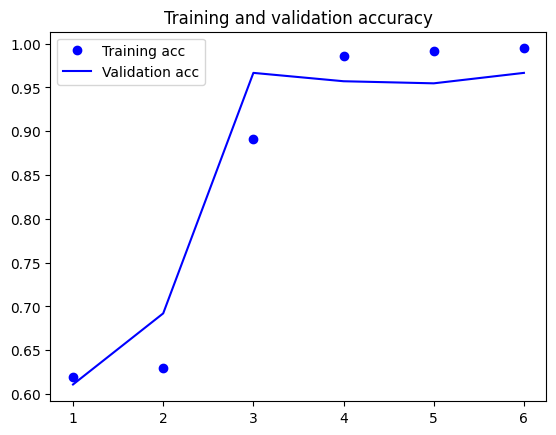

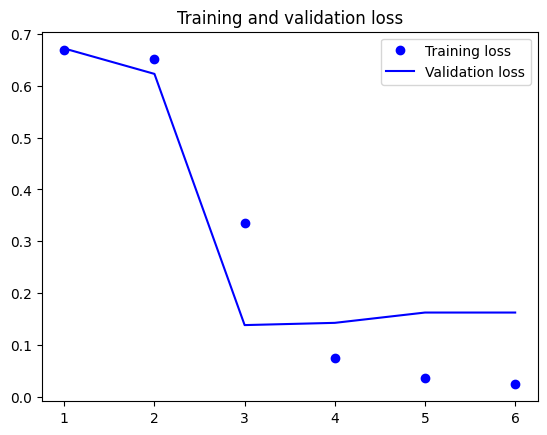

In [50]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Testing Model

In [51]:
model.evaluate(x_test,y_test)

14/14 [==============================] - 7s 489ms/step - loss: 0.0857 - acc: 0.9905


[0.08574491739273071, 0.9904534816741943]

In [54]:
model.save("Fake_News_Detector.h5")

/home/hassan-ahmed-khan/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Model Prediction

In [63]:
import numpy as np

for i in range(20):

    x_test_reshaped = np.expand_dims(x_test[i], axis=0)
    
    # Now predict
    prediction = model.predict(x_test_reshaped)
    if(y_test[i] == 1):
        print("Orignal lable = ","Real")
    else:
        print("Orignal lable = ","Fake")
        
    if(prediction > 0.5):
        print("Model Prediction = ","Real")
    else:
        print("Model Prediction = ","Fake")
# print(prediction)

1/1 [==============================] - 0s 308ms/step
Orignal lable =  Fake
Model Prediction =  Fake
1/1 [==============================] - 0s 439ms/step
Orignal lable =  Real
Model Prediction =  Real
1/1 [==============================] - 0s 294ms/step
Orignal lable =  Real
Model Prediction =  Real
1/1 [==============================] - 0s 364ms/step
Orignal lable =  Real
Model Prediction =  Real
1/1 [==============================] - 0s 370ms/step
Orignal lable =  Real
Model Prediction =  Real
1/1 [==============================] - 0s 343ms/step
Orignal lable =  Fake
Model Prediction =  Fake
1/1 [==============================] - 0s 286ms/step
Orignal lable =  Real
Model Prediction =  Real
1/1 [==============================] - 0s 409ms/step
Orignal lable =  Fake
Model Prediction =  Fake
1/1 [==============================] - 0s 321ms/step
Orignal lable =  Fake
Model Prediction =  Fake
1/1 [==============================] - 0s 363ms/step
Orignal lable =  Fake
Model Prediction =  Fake
